In [ ]:
%pip install boto3 bedrock-agentcore-starter-toolkit bedrock-agentcore strands-agents strands-agents-tools -qU

In [ ]:
from IPython import get_ipython
get_ipython().kernel.do_shutdown(True)

In [1]:
%store -r

# Amazon Bedrock AgentCore Gateway

Bedrock AgentCore Gateway provides customers a way to turn their existing Smithy APIs into fully-managed MCP servers without needing to manage infra or hosting. Customers can bring Smithy spec and transform them into mcp tools. We will demonstrate creating mcp tools from smithy model of Amazon S3. The agent will then be able to query Amazon S3 and answer questions related to the it.

The Gateway workflow involves the following steps to connect your agents to external tools:

- **Create the tools for your Gateway** - Define your tools using Smithy specification.
- **Create a Gateway endpoint** - Create the gateway that will serve as the MCP entry point with inbound authentication.
- **Add targets to your Gateway** - Configure the Smithy target that define how the gateway routes requests to specific tools. All the operations that part of Smithy file will become an MCP-compatible tool, and will be made available through your Gateway endpoint URL. Configure outbound authorization using AWS IAM for invoking Amazon S3 apis via Smithy.
- **Update your agent code** - Connect your agent to the Gateway endpoint to access all configured tools through the unified MCP interface.

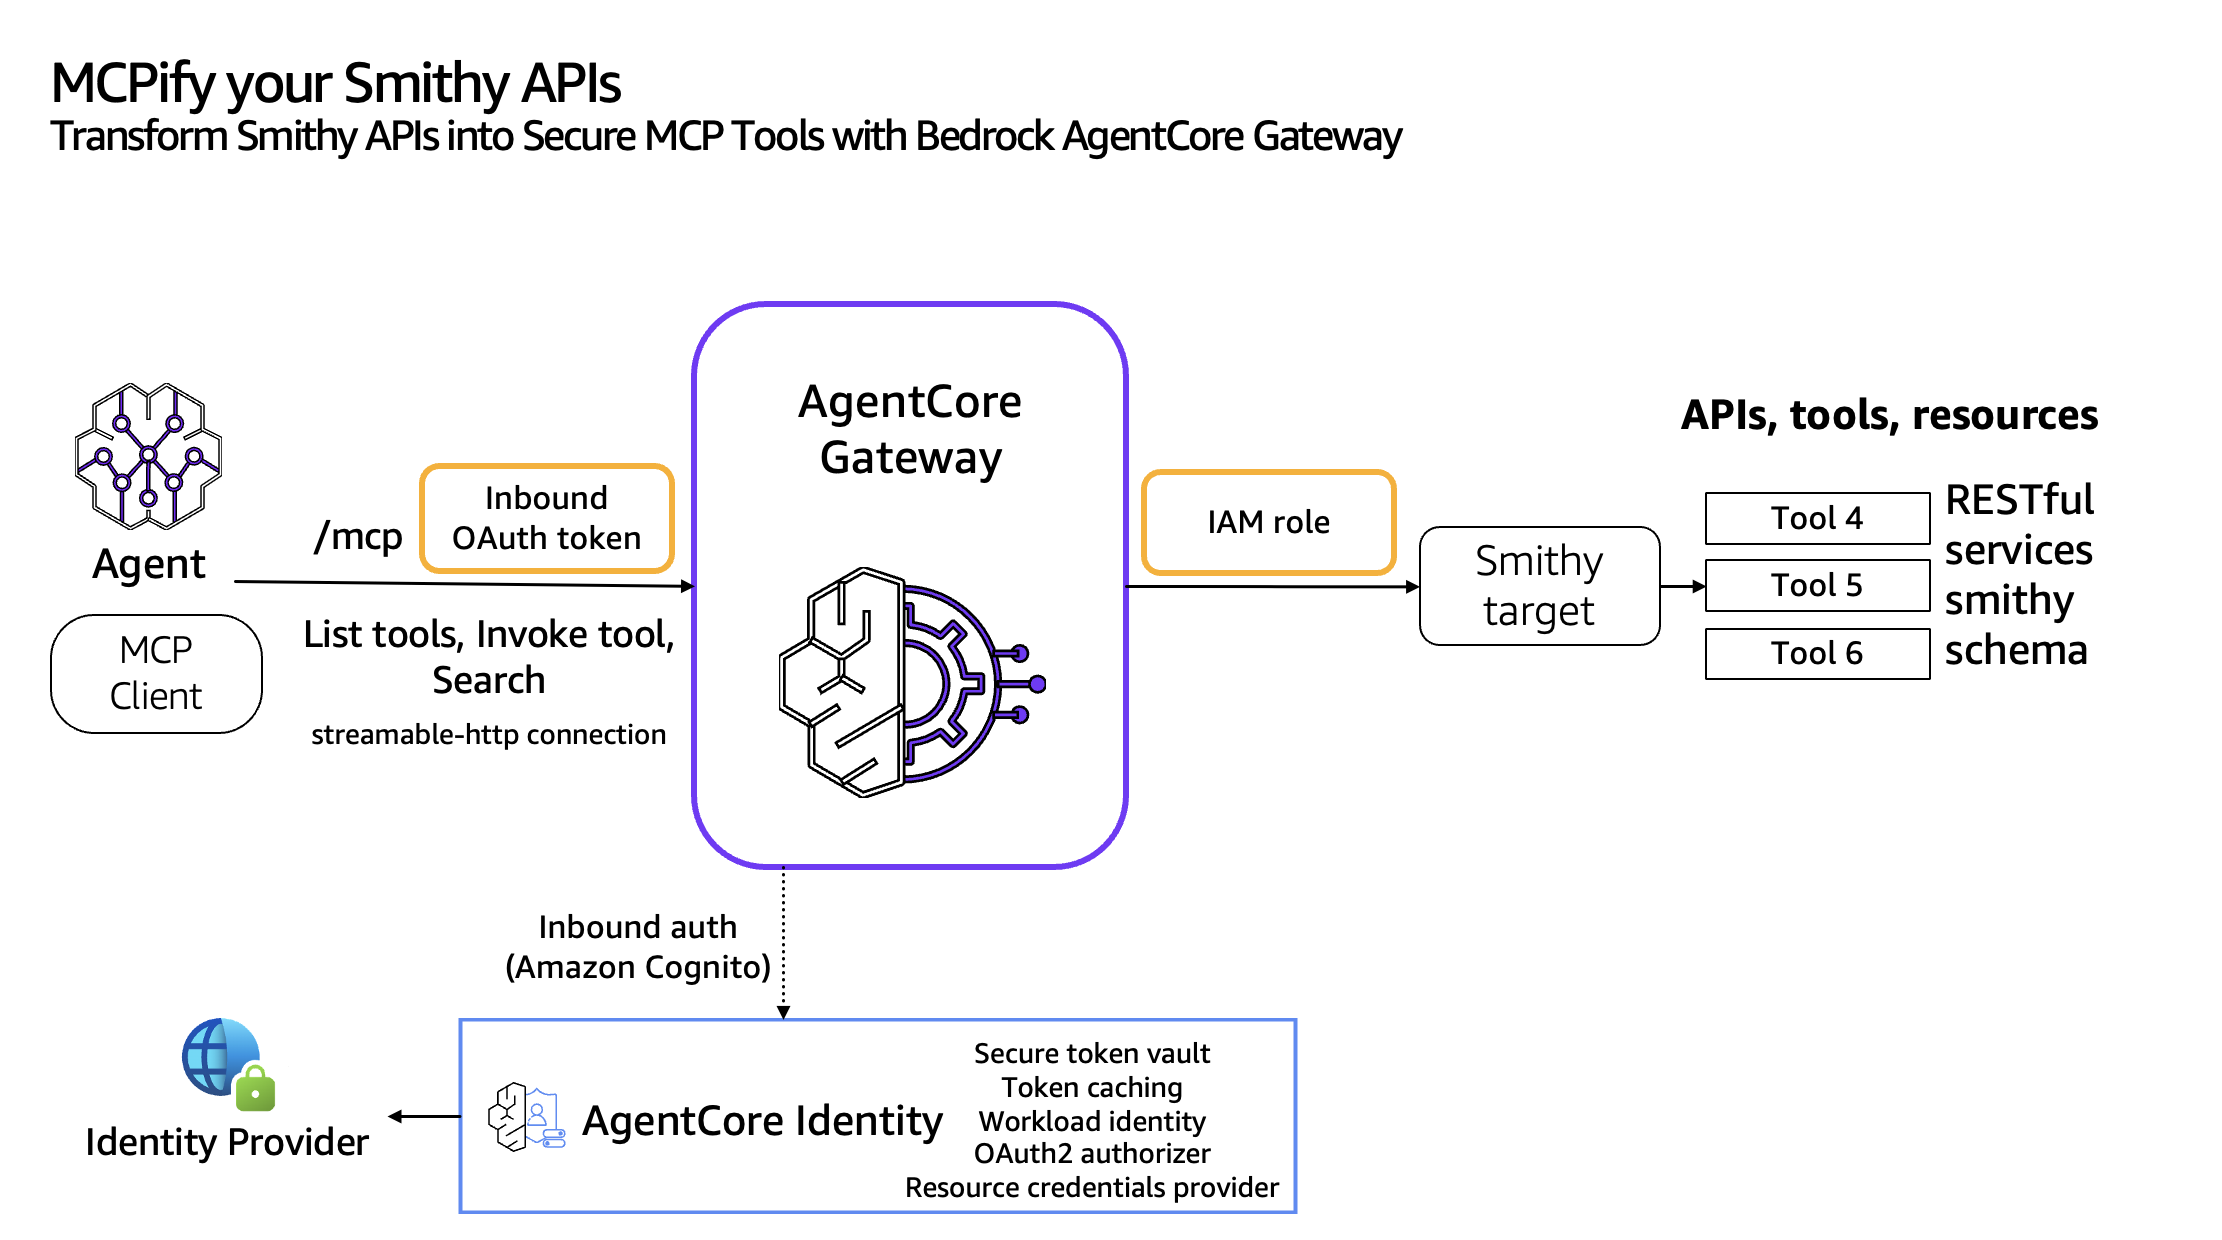

------

## Create the Gateway using the Python SDK

In [ ]:
from bedrock_agentcore_starter_toolkit.operations.gateway.client import GatewayClient
import logging
import boto3

region_name = boto3.Session().region_name

# setup the gateway
client = GatewayClient(region_name=region_name)
gateway = client.create_mcp_gateway()

In [ ]:
gateway

In [ ]:
# Store Gateway ID for later use
GATEWAY_ID = gateway["gatewayId"]
GATEWAY_URL = gateway["gatewayUrl"]
%store GATEWAY_ID GATEWAY_URL

Let's add permissions to invoke the SageMaker endpoint(s).

In [ ]:
import json

try:
    iam_client.put_role_policy(
        RoleName=role_name,
        PolicyName='SageMakerRuntimeInvokePermissions',
        PolicyDocument=json.dumps({
            "Version": "2012-10-17",
            "Statement": [
                {
                    "Effect": "Allow",
                    "Action": [
                        "sagemaker:InvokeEndpoint",
                        "sagemaker:InvokeEndpointWithResponseStream",
                        # "sagemaker:InvokeEndpointAsync", # Removed for now since it also requires S3 permissions
                    ],
                    "Resource": "*"  # Consider restricting to specific endpoint ARNs
                }
            ]
        })
    )
except iam_client.exceptions.NoSuchEntityException:
    print(f"Role {role_name} not found")
except iam_client.exceptions.LimitExceededException:
    print("Policy limit exceeded for this role")
except Exception as e:
    print(f"Error attaching policy: {str(e)}")

## Create the Gateway Target using Smithy

AWS API Models are available on [GitHub](https://github.com/aws/api-models-aws/).

In [ ]:
!wget https://raw.githubusercontent.com/aws/api-models-aws/refs/heads/main/models/sagemaker-runtime/service/2017-05-13/sagemaker-runtime-2017-05-13.json

In [ ]:
import boto3

# Create the agentcore client
agentcore_client = boto3.client('bedrock-agentcore-control')

# Create a Smithy model target
target = agentcore_client.create_gateway_target(
    gatewayIdentifier=GATEWAY_ID,
    name="SageMakerRuntimeTarget",
    targetConfiguration={
        "mcp": {
            "smithyModel": {
                "inlinePayload": open('sagemaker-runtime-2017-05-13.json', 'r').read()
            }
        }
    },
    credentialProviderConfigurations=[
        {
            "credentialProviderType": "GATEWAY_IAM_ROLE"
        }
    ]
)

In [ ]:
# Confirm the Gateway target is in READY state
agentcore_client.list_gateway_targets(gatewayIdentifier=GATEWAY_ID)

## Using with AI Agents

In this example, we'll use [Strands Agents](https://strandsagents.com), but any OSS framework with MCP support will work.

In [2]:
from strands import Agent
from strands.tools.mcp.mcp_client import MCPClient
from utils.cognito_utils import get_token
from utils.agent_utils import create_streamable_http_transport,get_full_tools_list 
import os

def run_agent(mcp_url: str, access_token: str):
    mcp_client = MCPClient(lambda: create_streamable_http_transport(mcp_url, access_token))
     
    with mcp_client:
        tools = get_full_tools_list(mcp_client)
        print(f"Found the following tools: {[tool.tool_name for tool in tools]}")

        # Create an agent with these tools
        agent = Agent(
            model="us.anthropic.claude-3-5-haiku-20241022-v1:0", tools=tools,
            system_prompt=f"""
                You are an expert data analyst and a product owner. Your task is to help the business thrive.

                # Sytems access
                You have access to a ML model for demand forecasting, exposed by the Amazon SageMaker AI endpoint {ENDPOINT_NAME}.
                This models takes an array of float as input, and returns an array of float as output.
            """
        )
        
        # Invoke the agent
        agent(
            f"These are the current demand values:\n\n<input>{test_sample}</input>\n\n"
            "Predict demand, please. Provide the output in JSON format {'predictions':<predictions>}"
        )
        
# run_agent(<MCP URL>, <Access token>)
run_agent(GATEWAY_URL, get_token(GATEWAY_ID))

User Pool ID:  us-east-1_pEniGgfhZ
Client ID:  7oivlvqfnfo1ck3g17pfiu37e4
Client Secret:  afp4mtta350q4vpg4h2i89udjut5a0rcouq8vdeg18acvqoi92k
Found the following tools: ['x_amz_bedrock_agentcore_search', 'SageMakerRuntimeTarget___InvokeEndpoint', 'SageMakerRuntimeTarget___InvokeEndpointAsync', 'SageMakerRuntimeTarget___InvokeEndpointWithResponseStream']
I'll help you predict the demand using the SageMaker endpoint for demand forecasting. I'll invoke the endpoint with the input data.
Tool #1: SageMakerRuntimeTarget___InvokeEndpoint
I'll format the predictions in JSON as you requested:

{'predictions': [86.79020690917969, 83.85835266113281, 81.7549819946289, 80.48657989501953, 80.43880462646484]}

The model has generated predictions for the next 5 time steps based on the input historical demand data. The predictions show a slight downward trend, starting at around 86.79 and gradually decreasing to about 80.44.

Would you like me to provide any additional analysis or insights about these 

The AI agent works! 🎉️ Note that some system prompting and context engineering is required to make sure that the model knows which endpoints are available, and what they do. To avoid this, you can create a custom MCP server where you provide explanation of the systems the model has access to directly in the docstring, so that it's exposed by the MCP server.

Now, we can decide to deploy it using Amazon Bedrock AgentCore Runtime, or any other AWS Compute service.